[*********************100%***********************]  1 of 1 completed


Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0288
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0191
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0197
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0185
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0204
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0201
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0198
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0206
Epoch 13/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0206
Epoch 14/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199
Epoch 15/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0212
Epoch 16/20
87/87 

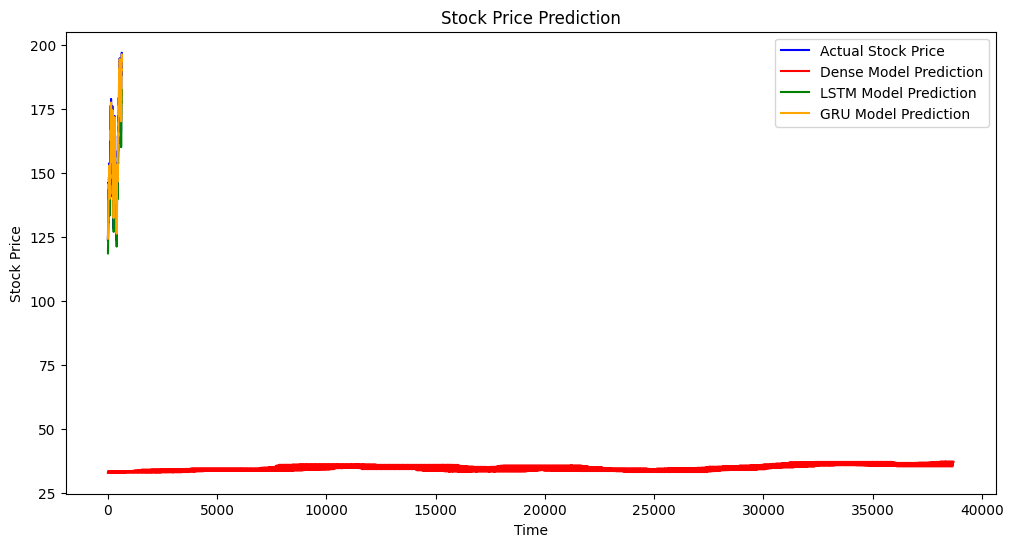

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Input

# Step 1: Collect Historical Stock Data
stock_symbol = 'AAPL'  # Example: Apple stock
stock_data = yf.download(stock_symbol, start='2010-01-01', end='2024-01-01')

# Use only 'Close' price for prediction
stock_data = stock_data[['Close']]

# Step 2: Preprocessing the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Split the data into training and test sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Step 3: Create Data Windows for Time-Series Prediction
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

# Reshape data to 3D for LSTM/GRU input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 4: Build Neural Network Architectures

# a. Simple Dense Network
model_dense = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Dense(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

model_dense.compile(optimizer='adam', loss='mean_squared_error')

# b. LSTM Network
model_lstm = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# c. GRU Network
model_gru = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    GRU(units=50, return_sequences=True),
    Dropout(0.2),
    GRU(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the Models
model_dense.fit(X_train, y_train, epochs=20, batch_size=32)
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)
model_gru.fit(X_train, y_train, epochs=20, batch_size=32)

# Step 6: Evaluate the Models
mse_dense = model_dense.evaluate(X_test, y_test)
mse_lstm = model_lstm.evaluate(X_test, y_test)
mse_gru = model_gru.evaluate(X_test, y_test)

print(f"MSE for Dense model: {mse_dense}")
print(f"MSE for LSTM model: {mse_lstm}")
print(f"MSE for GRU model: {mse_gru}")

# Step 7: Make Predictions
predicted_dense = model_dense.predict(X_test)
predicted_lstm = model_lstm.predict(X_test)
predicted_gru = model_gru.predict(X_test)

# Inverse transform the predictions and actual values
predicted_dense = scaler.inverse_transform(predicted_dense.reshape(-1, 1)) # Reshape to 2D
predicted_lstm = scaler.inverse_transform(predicted_lstm)
predicted_gru = scaler.inverse_transform(predicted_gru)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 8: Visualize the Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_dense, color='red', label='Dense Model Prediction')
plt.plot(predicted_lstm, color='green', label='LSTM Model Prediction')
plt.plot(predicted_gru, color='orange', label='GRU Model Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
